# Objektsegmentierung auf OpenCL-kompatiblen GPUs
APOC basiert auf [pyclesperanto](https://github.com/clEsperanto/pyclesperanto_prototype) und [scikit-learn](https://scikit-learn.org/stable/). Für die Objektsegmentierung verwendet es einen Pixelklassifikator und eine Zusammenhangskomponentenanalyse.

Beginnen wir mit dem Laden eines Beispielbildes und einiger Ground-Truth-Daten:

In [1]:
from skimage.io import imread, imsave
import pyclesperanto_prototype as cle
import numpy as np
import apoc

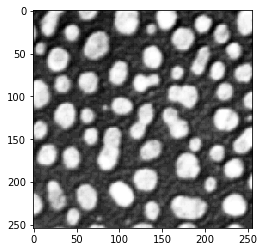

In [2]:
image = imread('../../data/blobs.tif')
cle.imshow(image)

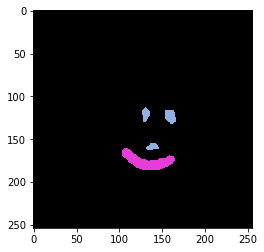

In [3]:
manual_annotations = imread('../../data/blobs_annotations.tif')

cle.imshow(manual_annotations, labels=True)

## Training
Wir trainieren jetzt einen ObjectSegmenter, der im Hintergrund ein [scikit-learn RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) ist. Nach dem Training wird der Klassifikator in [clij-kompatiblen OpenCL-Code](https://github.com/clEsperanto/clij-opencl-kernels) umgewandelt und unter einem gegebenen Dateinamen auf der Festplatte gespeichert.

In [4]:
# define features
features = apoc.PredefinedFeatureSet.medium_quick.value

# this is where the model will be saved
cl_filename = '../../data/blobs_object_segmenter.cl'

apoc.erase_classifier(cl_filename)
clf = apoc.ObjectSegmenter(opencl_filename=cl_filename, positive_class_identifier=2)
clf.train(features, manual_annotations, image)

## Vorhersage / Segmentierung
Der Klassifikator kann dann verwendet werden, um alle Pixel im gegebenen Bild zu klassifizieren. Ausgangspunkt ist wieder der Feature-Stack. Daher muss der Benutzer sicherstellen, dass für das Training und die Vorhersage die gleichen Features verwendet werden. Die Vorhersage kann auf der CPU mit dem ursprünglichen scikit-learn-Code und auf der GPU mit dem generierten OpenCL-Code durchgeführt werden. OCLRFC funktioniert gut, wenn beide Ergebnisbilder identisch aussehen.

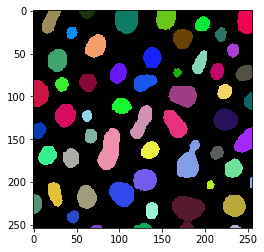

In [5]:
segmentation_result = clf.predict(features=features, image=image)
cle.imshow(segmentation_result, labels=True)

## Segmentierung mit einem geladenen Segmentierer

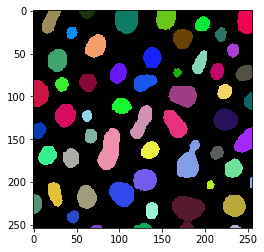

In [6]:
clf = apoc.ObjectSegmenter(opencl_filename=cl_filename)

segmentation_result = clf.predict(image=image)
cle.imshow(segmentation_result, labels=True)